In [163]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import sostenibilidad_fiscal as sf

In [164]:
Home = os.getcwd()

# Sostenibilidad fiscal

En el presente archivo sirve de documentación para el modelo de sosteniblidad fiscal. El modelo genera indicadores de sostenibilidad fiscal siendo estos cotas para el déficit primario o ingreso tributario según sea el caso para el sector público. Véase "Krejdl, A. (2006). Fiscal Sustainability – Definition , Indicators and Assessment of Czech Public Finance Sustainability. Working Papers 2006/3. Czech National Bank, Research Department."

Definiciones:

$b_0$ = deuda o SHRFSP en 0 (%pib) (inicial)

$b_t$ = deuda o SHRFSP en t (%pib)

$r_t$ = tasa de interés real en t

$c_t$ = crecimiento real del pib en t

$dp_t$ = déficit primario en t (%pib)

$r$ = tasa de interés real de largo plazo (constante)

$c$ = crecimiento real del pib de largo plazo (constante)

$g_t$ = gasto público neto en t (%pib)

$ip_t$ = ingreso petrolero en t (%pib)

$\tau_t$ = ingreso tributario en t (%pib)

$io_t$ = ingreso remanente en t (%pib)

$dp^*$ = déficit primario en sostenible (constante). Representa una cota superior [inferior] al déficit [superavit] del sector público. 

$\tau^*$ = déficit primario en sostenible (constante). Representa una cota inferior a los ingresos tributarios del gobierno. 



Ecuaciones:

1) Evolución de la deuda: $$b_t = \frac{1+r_t}{1+c_t}b_{t-1} + dp_t $$

Basado en la evolución de la deuda se construyen dos indicadores: el déficit primario sostenible y el ingreso tributario sostenible. Estos pueden ser construidos bajo horizonte de evaluación infinito (tasa de interés y de crecimiento real de largo plazo constantes donde r>c) o finito (no necesariamente constante ambas las tasas).

Horizonte infinito:

2) Déficit primario sostenible: $$ dp^{*} = b_{0} \frac{(r-c)}{(1+c)}  $$ 

3) Ingreso tributario sostenible: $$\tau^{*} = \frac{(r-c)}{(1+c)}( \sum_{t=1}^{T}{ [ (\frac{1+c}{1+r})^t (g_t-ip_t-io_t) ] + b_0 )} $$

Horizonte finito:

4) Déficit primario sostenible debe satisfacer: $$b_T = \prod_{t=1}^{T} \frac{1+r_t}{1+c_t} b_t + \sum_{t=1}^{T-1}[dp^{*} \prod_{t=1}^{T-1} \frac{1+r_{t+1}}{1+c_{t+1}} ] + dp*  $$

5) Ingreso tributario sostenible debe satisfacer: $$b_T = \prod_{t=1}^{T} \frac{1+r_t}{1+c_t} b_t + \sum_{t=1}^{T-1}[(g_t-ip_t-\tau^*-io_t) \prod_{t=1}^{T-1} \frac{1+r_{t+1}}{1+c_{t+1}} ] + (g_T-ip_T-\tau^*-io_T)  $$

Nota: la ecuación 3 asume que en algún punto $t=s$ para $s<\infty$, $g_t-ip_t-io_t$ es constante hasta el infinito. Esto da solución a la ecuación. Véase Andrade, M; Lugo, M. y Ortega, V. 2018. "Qué tan sostenible es la política fiscal en México: Un marco de evaluación para los próximos 25 años". Instituto Belisario Domínguez. Senado de la República.


# El presente ejercicio evalua la sosteniblidad fiscal para CGPE 2018

In [165]:
#cargar base de datos histórica para generar las tasa de interés y de crecimiento real de largo plazo

base = pd.read_excel('Datos modelo de sostenibilidad.xlsx',sheet_name = 'Datos 1990-2017')
base = base.set_index('año')

def generar_interes_crecimieto_lp(base):
    [deuda,def_pri] = [np.array(base['SHRFSP']), np.array(base['Balance primario'])*(-1)]
    [crec_pib,deuda_rez]= [np.array(base['Crecimiento real del PIB'])/100,
                           np.append( np.array([np.nan]), deuda )[0:-1]]
    interes_largo_plazo = ((deuda-def_pri)/deuda_rez)*(1+crec_pib)-1
    r_t = interes_largo_plazo.copy()
    interes_largo_plazo = np.mean(interes_largo_plazo[np.logical_not(np.isnan(interes_largo_plazo))])
    crecimiento_largo_plazo = np.mean(crec_pib[np.logical_not(np.isnan(crec_pib))])
    return interes_largo_plazo, crecimiento_largo_plazo, r_t

[r, c] = generar_interes_crecimieto_lp(base)[0:-1]  #acorde al modelo

# las tasa de interés el promedio de la tasa obtenida para los datos disponibles acorde a la ecuación 2
print('tasa de interés de largo plazo: ' + str(round(r*100,2)) + '%' )
print('tasa de crecimiento del PIB de largo plazo: ' + str(round(c*100,2)) + '%' )


tasa de interés de largo plazo: 7.04%
tasa de crecimiento del PIB de largo plazo: 2.49%


In [166]:
b_0 = base['SHRFSP'][2017] #valor inicial de la deuda pública (cierre de 2017)
print( 'valor inicial de la deuda pública (cierre de 2017) '+str(round(b_0,2))+'% = b_0' )

valor inicial de la deuda pública (cierre de 2017) 46.1% = b_0


In [167]:
base_f = pd.read_excel('Datos modelo de sostenibilidad.xlsx',sheet_name = 'Datos 2017-2023')
base_f = base_f.set_index('año')

In [168]:
#base de datos CGPE
r_t = generar_interes_crecimieto_lp(base_f)[-1] #tasa de interés explicita expost
base_f['interés'] = r_t
base_f = base_f.dropna()
ip_t = np.array( list(base_f['Ingresos petroleros']) )
tau_t = np.array( list(base_f['Ingresos tributarios']) )
io_t = np.array( list(base_f['Otros ingresos']) )
gpn_t = np.array( list(base_f['Gasto público neto']) )
cf_t = np.array( list(base_f['Costo financiero']) )
r_t = np.array( list(base_f['interés']) )
c_t = np.array( list(base_f['Crecimiento real del PIB']) )/100
g_t = gpn_t - cf_t
dp_t = g_t - ip_t - tau_t - io_t
[ip_m,io_m,g_m,tau_m]= [np.mean(ip_t),np.mean(io_t),np.mean(g_t),np.mean(tau_t)]
Deuda = sf.evolucion_deuda_dp(b_0, r_t, c_t, dp_t)

# Indicadores a horizonte infinito

In [169]:
dp_ss = sf.dp_star_infinito(b_0, r, c) #ecuación 2
print( 'Déficit primario sostenible en 2018 (% PIB): '+ str(round(dp_ss,2))+'%' )

Déficit primario sostenible en 2018 (% PIB): -2.04%


In [170]:
# se asume que después del año de 2023 el valor de cada serie es igual al promedio de los valores
# de 2018 a 2023. La tasa de interés y de crecimiento real es constante

tau_ss = sf.tau_star_infinito(b_0, r, c, ip_t, io_t, g_t, ip_m, io_m, g_m)
print( 'Ingreso tributario sostenible en 2018 (% PIB): '+ str(round(tau_ss,2))+'%' )



Ingreso tributario sostenible en 2018 (% PIB): 14.5%


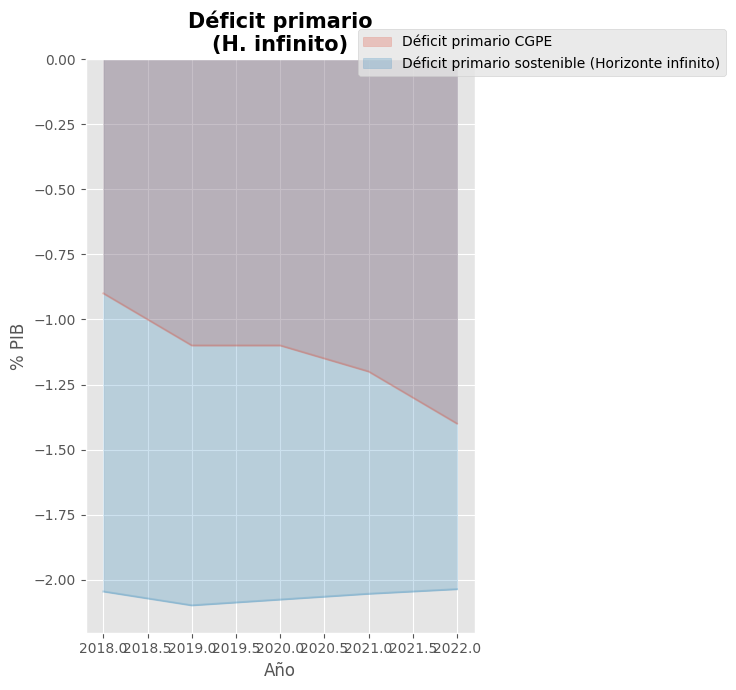

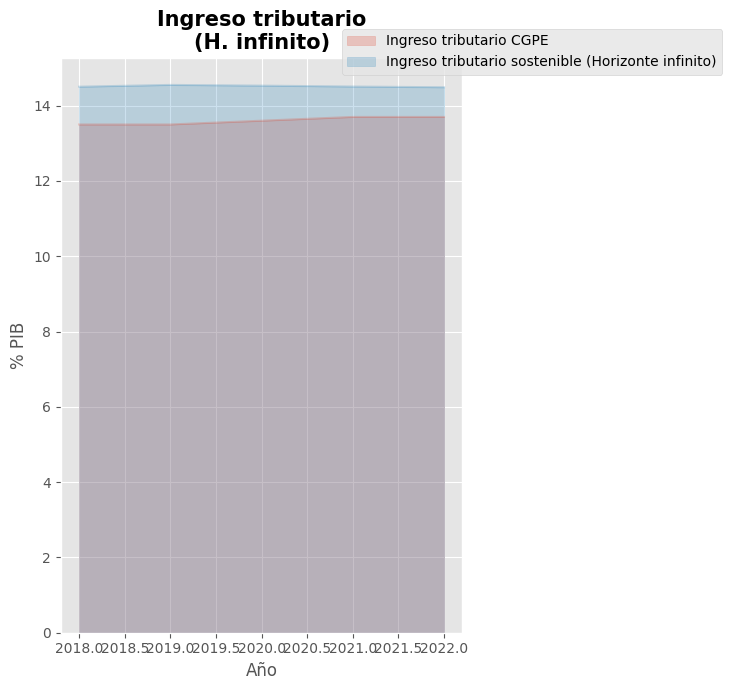

In [171]:
[serie_dp_ss,serie_tau_ss,N] = [[],[], 5]
for j in range(0,N):
    serie_dp_ss.append( sf.dp_star_infinito(Deuda[j],r,c) )
    serie_tau_ss.append( sf.tau_star_infinito(Deuda[j],r,c,ip_t[j:],io_t[j:],g_t[j:],ip_m,io_m,g_m) )
    
p = pd.DataFrame(dp_t).rename(columns={0:'Déficit primario CGPE'})

resultados=p.copy()
resultados['Ingreso tributario CGPE'] = list( tau_t )
p['Déficit primario sostenible (Horizonte infinito)'] = serie_dp_ss
p.index = list(range(2018, 2023))
f, axn = plt.subplots(1,1, figsize=(7,7),sharex=True)
axn.set_title('Déficit primario\n(H. infinito)',fontsize=15,fontweight = 'bold')
axn.set_ylabel('% PIB')
axn.set_xlabel('Año')
p.plot.area(stacked=False,alpha=.25,ax=axn,sharey=True).legend(loc=(.70,.97))
plt.tight_layout()

p = pd.DataFrame(tau_t).rename(columns={0:'Ingreso tributario CGPE'})
p['Ingreso tributario sostenible (Horizonte infinito)'] = serie_tau_ss
p.index = list(range(2018, 2023))
f, axn = plt.subplots(1,1, figsize=(7,7))
axn.set_title('Ingreso tributario\n(H. infinito)',fontsize=15,fontweight = 'bold')
axn.set_ylabel('% PIB')
axn.set_xlabel('Año')
p.plot.area(stacked=False,sharey=True,sharex=True,alpha=.25,ax=axn).legend(loc=(.70,.97))
plt.tight_layout()

resultados['Déficit primario sostenible (Horizonte infinito)'] = serie_dp_ss
resultados['Ingreso tributario sostenible (Horizonte infinito)'] = serie_tau_ss



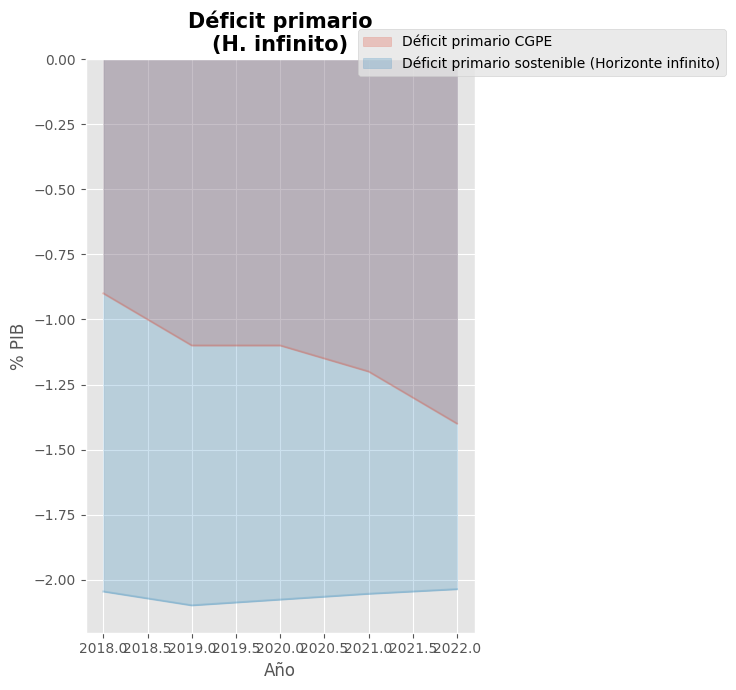

In [172]:
#El ejercio es el siguiente:
#Se calcula la deuda que se vería acorde a lo planteado por CGPE (con las tasas implícitas calculadas)
#Se calcula los indicadores dado que no ajuste para cada periodo
#i.e cada periodo b_0 se adelanta un periodo y calcula los indicadores dado el resto de las series.

[serie_dp_ss,serie_tau_ss,N] = [[],[], 5]
for j in range(0,N):
    serie_dp_ss.append( sf.dp_star_infinito(Deuda[j],r,c) )
    serie_tau_ss.append( sf.tau_star_infinito(Deuda[j],r,c,ip_t[j:],io_t[j:],g_t[j:],ip_m,io_m,g_m) )
    
p = pd.DataFrame(dp_t).rename(columns={0:'Déficit primario CGPE'})


resultados=p.copy()
resultados['Ingreso tributario CGPE'] = list( tau_t )

p['Déficit primario sostenible (Horizonte infinito)'] = serie_dp_ss
p.index = list(range(2018, 2023))
f, axn = plt.subplots(1,1, figsize=(7,7),sharex=True)
axn.set_title('Déficit primario\n(H. infinito)',fontsize=15,fontweight = 'bold')
axn.set_ylabel('% PIB')
axn.set_xlabel('Año')
p.plot.area(stacked=False,alpha=.25,ax=axn,sharey=True).legend(loc=(.70,.97))
plt.tight_layout()



# Indicadores de horizonte finito (evaluación de 2018 a 2023)

In [173]:
#se asume que b_2023 = b_2018
dp_ssf = sf.dp_star_finito(b_0,b_0,r_t.shape[0],r_t,c_t)
print( 'Déficit primario sostenible en 2018 (% PIB): '+ str(round(dp_ssf,2)) )

Déficit primario sostenible en 2018 (% PIB): -1.04


In [174]:
tau_ssf = sf.tau_star_finito(b_0,b_0,r_t,c_t,g_t,ip_t,io_t)
print( 'Ingreso tributario sostenible en 2018 (% PIB): '+ str(round(tau_ssf,2))+'%' )

Ingreso tributario sostenible en 2018 (% PIB): 13.5%


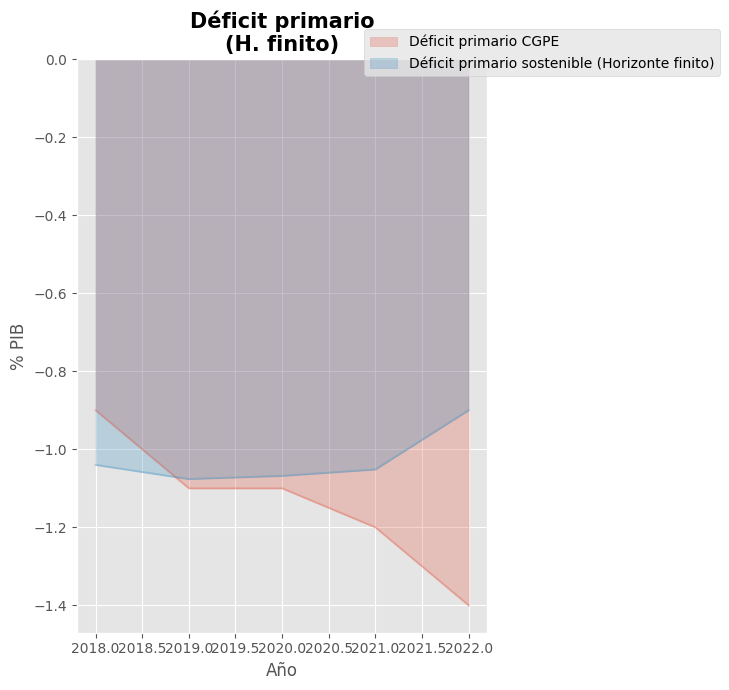

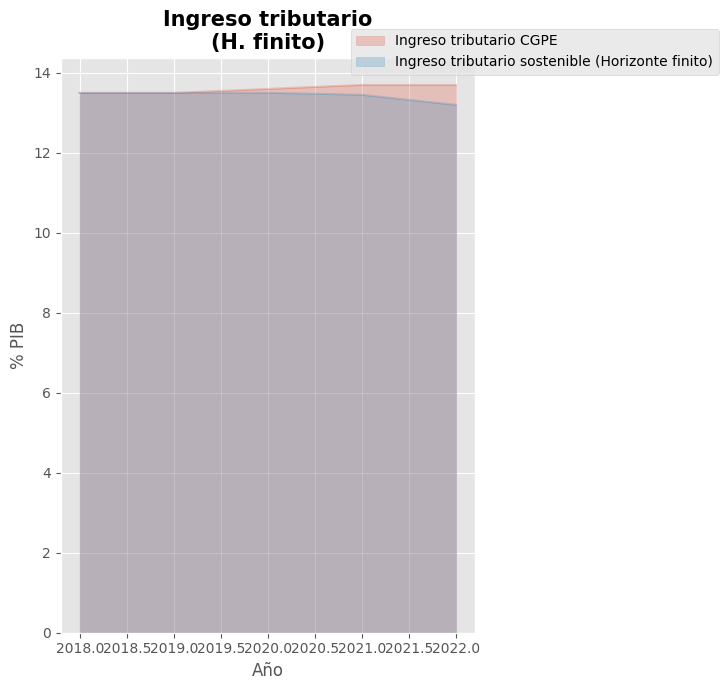

In [175]:
#El ejercio es el siguiente:
#Se calcula la deuda que se vería acorde a lo planteado por CGPE (con las tasas implícitas calculadas)
#Se calcula los indicadores dado que no ajuste para cada periodo
#i.e cada periodo b_0 se adelanta un periodo y calcula los indicadores dado el resto de las series.

[serie_dp_ssf,serie_tau_ssf,N] = [[],[], 5]
for j in range(0,N):
    serie_dp_ssf.append( sf.dp_star_finito(b_0,Deuda[j],r_t[j:].shape[0],r_t[j:],c_t[j:]) )
    serie_tau_ssf.append( sf.tau_star_finito(b_0,Deuda[j],r_t[j:],c_t[j:],g_t[j:],ip_t[j:],io_t[j:]) )

p = pd.DataFrame(dp_t).rename(columns={0:'Déficit primario CGPE'})
p['Déficit primario sostenible (Horizonte finito)'] = serie_dp_ssf
p.index = list(range(2018, 2023))
f, axn = plt.subplots(1,1, figsize=(7,7),sharex=True)
axn.set_title('Déficit primario\n(H. finito)',fontsize=15,fontweight = 'bold')
axn.set_ylabel('% PIB')
axn.set_xlabel('Año')
p.plot.area(stacked=False,alpha=.25,ax=axn,sharey=True).legend(loc=(.70,.97))
plt.tight_layout()

resultados['Déficit primario sostenible (Horizonte finito)'] = serie_dp_ssf


p = pd.DataFrame(tau_t).rename(columns={0:'Ingreso tributario CGPE'})
p['Ingreso tributario sostenible (Horizonte finito)'] = serie_tau_ssf
p.index = list(range(2018,2023))
f, axn = plt.subplots(1,1, figsize=(7,7),sharex=True)
axn.set_title('Ingreso tributario\n(H. finito)',fontsize=15,fontweight = 'bold')
axn.set_ylabel('% PIB')
axn.set_xlabel('Año')
p.plot.area(stacked=False,alpha=.25,ax=axn,sharey=True).legend(loc=(.70,.97))
plt.tight_layout()

resultados['Ingreso tributario sostenible (Horizonte finito)'] = serie_tau_ssf



# Análisis de sensibilidad

In [176]:
#El análisis de sensibilidad está hecho para los indicadores de horizonte infinito.
#El ejercicio es el siguiente: obtener los indicadores a diferentes combinaciones de tasa de interés y 
#crecimiento real de la economía.
print('Déficit sostenible para diferente combinaciones interés y crecimiento, horizonte infinito')
sf.sensibilidad_dp_ss(b_0, 11, 0, .1)

Déficit sostenible para diferente combinaciones interés y crecimiento, horizonte infinito


Inteŕes real,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
Crecimiento real,,,,,,,,,,,
0.00,-0.0,-0.461,-0.922000,-1.383000,-1.844000,-2.305000,-2.766000,-3.227000,-3.688000,-4.149000,-4.610000
0.01,0.0,-0.000,-0.456436,-0.912871,-1.369307,-1.825743,-2.282178,-2.738614,-3.195050,-3.651485,-4.107921
0.02,0.0,0.000,-0.000000,-0.451961,-0.903922,-1.355882,-1.807843,-2.259804,-2.711765,-3.163725,-3.615686
0.03,0.0,0.000,0.000000,-0.000000,-0.447573,-0.895146,-1.342718,-1.790291,-2.237864,-2.685437,-3.133010
0.04,0.0,0.000,0.000000,0.000000,-0.000000,-0.443269,-0.886538,-1.329808,-1.773077,-2.216346,-2.659615
0.05,0.0,0.000,0.000000,0.000000,0.000000,-0.000000,-0.439048,-0.878095,-1.317143,-1.756190,-2.195238
0.06,0.0,0.000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.434906,-0.869811,-1.304717,-1.739623
0.07,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.430841,-0.861682,-1.292523
0.08,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.426852,-0.853704


In [177]:
print('Ingreso tributario sostenible para diferente combinaciones interés y crecimiento, horizonte infinito')
sf.sensibilidad_tau_ss(b_0, 11, 0, .1, ip_t, io_t, g_t, ip_m, io_m, g_m)

Ingreso tributario sostenible para diferente combinaciones interés y crecimiento, horizonte infinito


Inteŕes real,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
Crecimiento real,,,,,,,,,,,
0.00,12.46,12.920949,13.381789,13.842514,14.303113,14.763579,15.223900,15.684069,16.144075,16.603906,17.063552
0.01,0.00,12.460000,12.916385,13.372665,13.828831,14.284874,14.740786,15.196559,15.652181,16.107645,16.562938
0.02,0.00,0.000000,12.460000,12.911911,13.363719,13.815416,14.266992,14.718441,15.169753,15.620918,16.071928
0.03,0.00,0.000000,0.000000,12.460000,12.907524,13.354947,13.802261,14.249458,14.696529,15.143467,15.590261
0.04,0.00,0.000000,0.000000,0.000000,12.460000,12.903222,13.346344,13.789359,14.232260,14.675038,15.117686
0.05,0.00,0.000000,0.000000,0.000000,0.000000,12.460000,12.899001,13.337905,13.776703,14.215390,14.653957
0.06,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,12.460000,12.894860,13.329624,13.764286,14.198838
0.07,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.460000,12.890796,13.321499,13.752101
0.08,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.460000,12.886808,13.313524


# Conclusiones

1) Los indicadores de horizonte infinito señalan una política fiscal insostenible.

Esto se debe a que el superávit sostenible (- deficit sostenible) es mayor al que muestra CGPE => insostenible

El valor de los ingresos tributarios sostenibles es mayor a los ingresos presupuestados por CGPE => insostenible

2) Los indicadores de horizonte finito señalan una política fiscal sostenible.

Sucede el caso contrario al horizonte finito para los índicadores.

3) ¿Por qué en H. infinito y en H. finito la política fiscal es sostenible y no sostenible respectivamente?

Respuesta: la tasa de interés, el crecimiento real de la economía y los déficit primarios pronosticados por CGPE. La series de tasa de interés observadas son mucho mayores a lo que indicaria el mismo ejercicio realizado para la propuesta de CGPE. Las observadas son 7% y las pronosticadas con 4.7%. La tasa de crecimiento real de la economía observada fue de 2.6% y la pronosticada es de 3.25%. Aunado a lo anterior se tiene superavit primarios pronósticados para los periodos siguientes en CGPE lo que en lo observado simplemente no se da. Es decir, los pronósticos de CGPE son demasiado optimistas con relación a lo observado.



In [178]:
#tasas de interés real observadas y pronósticas promedio respectivamente
r,np.mean(r_t)

(0.07039962523293361, 0.061283532603409616)

In [179]:
#tasas de crecimiento del pib real observadas y pronósticas promedio respectivamente
c,np.mean(c_t)

(0.024936672778310003, 0.038)

In [180]:
resultados.to_excel('resultados.xlsx')
sf.sensibilidad_dp_ss(b_0,11,0,.1).to_excel('sensibilidad déficit primario.xlsx')
sf.sensibilidad_tau_ss(b_0,11,0,.1,ip_t,io_t,g_t,ip_m,io_m,g_m).to_excel('sensibilidad ingreso tributario.xlsx')

In [181]:
Debt = pd.DataFrame(Deuda).rename(columns={0:'Deuda'})
Debt['Deuda con déficit sostenible (H. infinito)'] = sf.evolucion_deuda_dp(b_0, r_t, c_t, np.ones((5))*dp_ss)
Debt['Deuda con déficit sostenible (H. finito)'] = sf.evolucion_deuda_dp(b_0, r_t, c_t, np.ones((5))*dp_ssf)
Debt['Deuda con ingreso tributario sostenible (H. infinito)'] = sf.evolucion_deuda_tau(b_0, r_t, c_t, g_t, ip_t, io_t, np.ones((5))*tau_ss)
Debt['Deuda con ingreso tributario sostenible (H. finito)'] = sf.evolucion_deuda_tau(b_0, r_t, c_t, g_t, ip_t, io_t, np.ones((5))*tau_ssf)
Debt.index = range(2017, 2023)
Debt.to_excel('Deuda.xlsx')